In [1]:
# Cell 1: Imports (MODIFIED FOR ROBUST DEVICE SELECTION)
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
from scipy.linalg import eigh, eigvalsh # Use eigvalsh for spectral gap
from math import sqrt
import warnings
import time
from tqdm.auto import tqdm

# Configure plots (Keep as is)
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['font.size'] = 10
warnings.filterwarnings("ignore", category=RuntimeWarning) # Suppress common warnings

# --- Robust Device Selection ---
global_device = None # Initialize
print("--- Determining Execution Device ---")
if torch.cuda.is_available():
    print("CUDA detected. Attempting to use GPU...")
    try:
        # Try allocating a small tensor on GPU 0 to check availability
        _ = torch.tensor([1.0], device='cuda:0')
        global_device = torch.device('cuda:0')
        dev_name = torch.cuda.get_device_name(0)
        print(f"✅ Successfully accessed GPU 0: {dev_name}. Using GPU.")
    except Exception as e_gpu_test:
        print(f"⚠️ Warning: Could not access CUDA device 0, even though CUDA is available. Error: {e_gpu_test}")
        print("   Falling back to CPU.")
        global_device = torch.device('cpu')
else:
    print("⚠️ CUDA not available. Using CPU.")
    global_device = torch.device('cpu')

print(f"Selected Device: {global_device}")
# --- End Robust Device Selection ---

# Ensure mpmath is imported if used later (keep try-except block)
try:
    import mpmath as mp
    mp.dps = 25 # Set precision
    print("✅ mpmath imported successfully.")
except ImportError:
    print("⚠️ mpmath library not found. zeta_prime_over_zeta function will fail if called.")
    # Define dummy function if needed by later cells, even if it errors
    def zeta_prime_over_zeta(s):
        raise ImportError("mpmath not installed, cannot calculate zeta function.")

print("✅ Cell 1: Imports and Robust Device Selection complete.")

--- Determining Execution Device ---
CUDA detected. Attempting to use GPU...
✅ Successfully accessed GPU 0: NVIDIA GeForce RTX 2060. Using GPU.
Selected Device: cuda:0
✅ mpmath imported successfully.
✅ Cell 1: Imports and Robust Device Selection complete.


In [2]:
# Cell 2: Riemann Zeta Function Derivative Calculation (Keep as is)
# (Assuming this complex calculation is intended as the source)
try:
    import mpmath as mp
    mp.dps = 25 # Set precision

    def zeta_prime_over_zeta(s):
        """Computes ζ'(s)/ζ(s) using mpmath."""
        try:
            # Avoid potential issues exactly at poles or known zeros if needed
            if s == 1: return mp.nan
            # Use mpmath's zeta function and its derivative
            val = mp.zeta(s)
            if val == 0: return mp.inf # Handle zeros of zeta
            prime_val = mp.zeta(s, derivative=1)
            return prime_val / val
        except Exception:
            return mp.nan # Return NaN on calculation errors

    print("zeta_prime_over_zeta function defined using mpmath.")

except ImportError:
    print("mpmath library not found. Please install it (`pip install mpmath`).")
    # Define a dummy function if mpmath is not available
    def zeta_prime_over_zeta(s):
        print("Error: mpmath not installed.")
        return np.nan

zeta_prime_over_zeta function defined using mpmath.


In [3]:
# Cell 3: Configuration (MODIFIED FOR SINGLE ORGANISM)

print("--- Configuration: Single Zeta-Kernel System ---")

# === CORE MODIFICATION: Force Single Organism ===
M = 1 # Number of organisms (FORCED TO 1)
print(f"Number of Organisms (M): {M} (Forced Single System)")
# ===============================================

N = 20 # Number of nodes per organism (Size of state vector f)
MAX_T = 800 # Number of simulation timesteps
T_REFRESH = 100 # How often to recompute the kernel R

# Parameters for generating the kernel R from zeta function flow
T_VALS_CENTER = 100.0 # Center point on the critical line (0.5 + it)
T_VALS_WIDTH = 0.1 # Range around the center to sample t values from
T_DRIFT_SPEED = 0.0005 # How fast t_vals drift over time
BETA_KERNEL = 1.0 # Decay parameter for constructing R: exp(-beta * |flow_i-flow_j|) / sqrt(...)
KERNEL_EPS = 1e-6 # Small epsilon to avoid division by zero in kernel

# Parameters for the dynamical system f(t+1) = sigma(R*f + noise)
ACTIVATION_MIX = 0.8 # Blend between tanh (1-mix) and sin (mix)
NOISE_LEVEL = 0.02

# Coupling (DISABLED FOR M=1)
# coupling_strength = 0.005 # Strength of coupling between organisms (Not used if M=1)
print(f"Coupling Strength: 0 (Disabled for single system)")

# Analysis
SPECTRAL_GAP_INTERVAL = 10 # How often to compute spectral gap

# --- Define the "collapse" function - MODIFIED TO BYPASS ---
# mu_iter = {1: 1, 2: -1, 3: -1} # Original flawed truncated Mobius terms - NO LONGER USED
# max_n_iter = max(mu_iter.keys()) # NO LONGER USED

def bypass_collapse(R, mu_dict=None):
    """
    Placeholder function. Returns the input matrix R unmodified.
    This replaces the flawed truncated prime-collapse operator.
    The dynamics will use the original zeta-derived kernel R.
    """
    # print("  (Note: Bypassing truncated collapse operator. Using original R.)") # Reduce verbosity
    return R

print(f"Node vector size (N): {N}")
print(f"Simulation steps (MAX_T): {MAX_T}")
print(f"Kernel Refresh Interval (T_REFRESH): {T_REFRESH}")
print(f"Dynamics: Activation Mix={ACTIVATION_MIX}, Noise Level={NOISE_LEVEL}")
print("Kernel Generation: Based on ζ'/ζ flow.")
print("Operator Used: Original zeta-derived kernel R (Truncated collapse BYPASSED)")

--- Configuration: Single Zeta-Kernel System ---
Number of Organisms (M): 1 (Forced Single System)
Coupling Strength: 0 (Disabled for single system)
Node vector size (N): 20
Simulation steps (MAX_T): 800
Kernel Refresh Interval (T_REFRESH): 100
Dynamics: Activation Mix=0.8, Noise Level=0.02
Kernel Generation: Based on ζ'/ζ flow.
Operator Used: Original zeta-derived kernel R (Truncated collapse BYPASSED)


In [4]:
# Cell 4: System Initialization (MODIFIED FOR SINGLE ORGANISM & global_device & sys import)

import sys # <--- ADD THIS IMPORT
import numpy as np
import pandas as pd
import torch
import warnings
# Assuming mpmath might be needed, handle import carefully
try:
    import mpmath as mp
except ImportError:
    mp = None # Set mp to None if import fails
# Assuming bypass_collapse is defined elsewhere (e.g., Cell 3) or implicitly defined

print("--- Initializing System State (Single Organism) ---")

# --- Check prerequisites defined in previous cells ---
initialization_error = False
required_globals_init = ['M', 'N', 'T_VALS_CENTER', 'T_VALS_WIDTH', 'T_DRIFT_SPEED',
                         'BETA_KERNEL', 'KERNEL_EPS', 'global_device', 'zeta_prime_over_zeta',
                         'bypass_collapse', 'ACTIVATION_MIX', 'NOISE_LEVEL'] # Added missing config vars
missing_prereqs_init = [v for v in required_globals_init if v not in globals()]
if missing_prereqs_init:
    print(f"❌ ERROR: Missing prerequisites for initialization: {missing_prereqs_init}")
    initialization_error = True

# Check mpmath availability if zeta function is used
# Now 'sys' is defined
if 'mp' not in sys.modules and 'mpmath' not in sys.modules:
     if mp is None: # Check our flag from import attempt
          print("⚠️ mpmath needed for zeta function but not installed. Initialization will likely fail.")
          # Define dummy if needed, though error will likely occur anyway
          if 'zeta_prime_over_zeta' not in globals():
              def zeta_prime_over_zeta(s): raise ImportError("mpmath missing")
     # else: mp was imported successfully earlier or here

# Initialize mpmath precision if available
if mp is not None:
    try:
        mp.dps = 25
    except AttributeError: # Handle cases where mp might be None despite passing module check
        print("Warning: mp variable exists but cannot set dps.")
        mp = None # Reset mp to None

organisms = [] # List to hold organism data (will contain only one dict)

if not initialization_error:
    # Loop creates only one organism due to M=1
    for i in range(M):
        # Initial t values for generating the kernel flow
        t_center_instance = T_VALS_CENTER + (i - (M-1)/2) * T_VALS_WIDTH * 2
        t_vals = np.linspace(t_center_instance - T_VALS_WIDTH / 2,
                             t_center_instance + T_VALS_WIDTH / 2, N)

        print(f"  Calculating initial flow values for Organism {i+1} (t center ~ {t_center_instance:.2f})...")
        # Calculate flow = |zeta'/zeta(0.5 + it)|
        s_vals = 0.5 + 1j * t_vals
        flow_vals = np.zeros(N, dtype=float)
        valid_flow = True
        for idx, s in enumerate(s_vals):
             try:
                 # Call zeta function (ensure it's defined, might error if mpmath missing)
                 z_prime_over_z = zeta_prime_over_zeta(s)
                 # Handle mpmath types correctly if mp is available
                 if mp is not None and (isinstance(z_prime_over_z, mp.mpc) or isinstance(z_prime_over_z, mp.mpf)):
                     flow_vals[idx] = float(mp.fabs(z_prime_over_z)) if mp.isfinite(z_prime_over_z) else np.nan
                 elif isinstance(z_prime_over_z, (complex, float, int)): # Handle standard types
                      flow_vals[idx] = np.abs(z_prime_over_z) if np.isfinite(z_prime_over_z) else np.nan
                 else: # Handle mp.inf or other non-numeric types returned by dummy
                      flow_vals[idx] = np.nan
             except ImportError: # Catch error if dummy zeta func was called
                  print("  ERROR: mpmath missing, cannot calculate zeta derivative.")
                  valid_flow = False; break # Stop processing flow values
             except Exception as e_zeta:
                 print(f"    Error calculating zeta derivative at s={s}: {e_zeta}")
                 flow_vals[idx] = np.nan
                 valid_flow = False

        if not valid_flow or np.isnan(flow_vals).any():
             print(f"  ERROR: Failed to calculate valid flow values for Organism {i+1}. Cannot initialize.")
             raise ValueError("Failed to calculate initial zeta flow values.")

        # --- Build the initial Relational Kernel R from flow values ---
        R = np.zeros((N, N), dtype=float)
        diffs_abs = np.abs(flow_vals[:, None] - flow_vals[None, :])
        sqrt_diffs = np.sqrt(np.maximum(diffs_abs, 0) + KERNEL_EPS)
        with np.errstate(divide='ignore', invalid='ignore'):
            R = np.exp(-BETA_KERNEL * diffs_abs) / sqrt_diffs
        R[np.isnan(R)] = 0
        R = (R + R.T) / 2
        np.fill_diagonal(R, 0)

        # --- MODIFICATION: Bypass the collapse operator ---
        # C = bypass_collapse(R) # This just returns R
        # Store the *original* R, not a collapsed version C
        # *** Use global_device defined in Cell 1 ***
        R_tensor = torch.tensor(R, dtype=torch.float32).to(global_device)
        print(f"  Kernel R for Organism {i+1} calculated and moved to {global_device}.")

        # Initialize state vector f and other properties
        f_init = torch.randn(N, dtype=torch.float32).to(global_device) * 0.1
        organisms.append({
            "id": i,
            "t_vals": t_vals,
            "flow_vals": flow_vals,
            "R": R_tensor,
            "f": f_init,
            "f_history": [f_init.cpu().numpy().copy()],
            "std_history": [torch.std(f_init).item()],
            "spectral_gap_history": [],
            "dynamic_param_history": [],
            "activation_mix": ACTIVATION_MIX,
            "noise_level": NOISE_LEVEL
        })

    print(f"Initialized {len(organisms)} organism(s).")

else:
    print("❌ Skipping Initialization due to missing prerequisites.")

print("✅ Cell 4 execution complete.")

--- Initializing System State (Single Organism) ---
  Calculating initial flow values for Organism 1 (t center ~ 100.00)...
  Kernel R for Organism 1 calculated and moved to cuda:0.
Initialized 1 organism(s).
✅ Cell 4 execution complete.


In [5]:
# Cell 5: Simulation Step Function (MODIFIED FOR SINGLE ORGANISM, SAFETY CHECKS)

print("--- Defining Simulation Step Function ---")

def update_organisms(organisms_list, t):
    """Performs one simulation step for all organisms."""

    # --- No Coupling Calculation for M=1 ---
    # if len(organisms_list) > 1:
    #     all_states = torch.stack([o["f"] for o in organisms_list])
    #     mean_state = torch.mean(all_states, dim=0)
    # else:
    #     mean_state = organisms_list[0]["f"] # Doesn't matter for M=1

    # --- Update loop (will only run once for M=1) ---
    avg_changes = [] # Track average change for convergence check (optional)
    fatal_error = False # Flag for halting

    for o in organisms_list: # Loop runs only once
        # --- Input Calculation: R * f ---
        # Use the stored kernel R (which is the original zeta-derived kernel)
        try:
            # Ensure R is on the correct device
            if o["R"].device != o["f"].device:
                 o["R"] = o["R"].to(o["f"].device)
            raw = torch.matmul(o["R"], o["f"])
        except Exception as e_matmul:
             print(f"!!! ERROR during matmul for organism {o['id']} at step {t}: {e_matmul} !!!")
             print(f"    R shape: {o['R'].shape}, dtype: {o['R'].dtype}, device: {o['R'].device}")
             print(f"    f shape: {o['f'].shape}, dtype: {o['f'].dtype}, device: {o['f'].device}")
             fatal_error = True; break

        # --- Apply Activation, Noise ---
        # No external drive term needed for M=1
        # ext_drive = coupling_strength * (mean_state - o["f"]) # REMOVED

        new_f = (o["activation_mix"] * torch.sin(raw) +
                 (1.0 - o["activation_mix"]) * torch.tanh(raw) +
                 torch.randn_like(o["f"]) * o["noise_level"]) # Removed ext_drive

        # --- SAFETY CHECK: Check for NaNs or Infs ---
        if torch.isnan(new_f).any() or torch.isinf(new_f).any():
            print(f"!!! WARNING: NaN or Inf detected in state vector for organism {o['id']} at step {t}. Halting simulation. !!!")
            # Option 1: Raise an error to stop everything
            # raise ValueError(f"Unstable dynamics detected at step {t}")
            # Option 2: Set flag and break loop
            fatal_error = True; break # Stop processing organisms

        # --- Store results ---
        avg_change = torch.mean(torch.abs(new_f - o["f"])).item()
        avg_changes.append(avg_change)
        o["f"] = new_f
        o["f_history"].append(new_f.cpu().numpy().copy())
        o["std_history"].append(torch.std(new_f).item())
        # Spectral gap calculation can remain, called periodically outside this func

    # Return avg change and error status
    mean_avg_change = np.mean(avg_changes) if avg_changes else 0.0
    return mean_avg_change, fatal_error

print("Simulation step function `update_organisms` defined.")

--- Defining Simulation Step Function ---
Simulation step function `update_organisms` defined.


In [6]:
# Cell 6: Kernel Refresh Function (MODIFIED TO ACCEPT DEVICE ARGUMENT)

print("--- Defining Kernel Refresh Function ---")

# **** ADD 'target_device' AS AN ARGUMENT ****
def refresh_kernels(organisms_list, t, target_device):
    """Periodically recalculates flow values and the R kernel."""
    # print(f"\n--- Refreshing Kernel at Step {t} ---") # Reduce verbosity inside loop
    refresh_error = False # Flag for errors during refresh

    # Loop runs once for M=1
    for o in organisms_list:
        # 1. Drift t_vals
        drift = np.random.uniform(-T_DRIFT_SPEED, T_DRIFT_SPEED, size=N)
        o["t_vals"] += drift

        # 2. Recalculate flow values
        # print(f"  Recalculating flow values for Organism {o['id']}...") # Reduce verbosity
        s_vals_new = 0.5 + 1j * o["t_vals"]
        flow_vals_new = np.zeros(N, dtype=float)
        valid_flow = True
        for idx, s in enumerate(s_vals_new):
            try:
                # Assuming zeta_prime_over_zeta is globally available
                z_prime_over_z = zeta_prime_over_zeta(s)
                if mp is not None and (isinstance(z_prime_over_z, mp.mpc) or isinstance(z_prime_over_z, mp.mpf)):
                     flow_vals_new[idx] = float(mp.fabs(z_prime_over_z)) if mp.isfinite(z_prime_over_z) else np.nan
                elif isinstance(z_prime_over_z, (complex, float, int)):
                      flow_vals_new[idx] = np.abs(z_prime_over_z) if np.isfinite(z_prime_over_z) else np.nan
                else: flow_vals_new[idx] = np.nan
                # Check for NaN immediately
                if np.isnan(flow_vals_new[idx]):
                    valid_flow = False; # print(f"    NaN detected at s={s}") # Debug print
                    break # Stop calculating flow for this organism if one fails
            except Exception as e_zeta_ref:
                print(f"    Error calculating zeta derivative at s={s}: {e_zeta_ref}")
                valid_flow = False; break # Stop calculating flow

        if not valid_flow: # Check if any error occurred during flow calculation
             print(f"  ERROR: Failed to calculate valid flow values during refresh for Organism {o['id']}. Keeping old kernel.")
             refresh_error = True; continue # Skip kernel update

        o["flow_vals"] = flow_vals_new # Store updated flow values only if all are valid

        # 3. Rebuild Kernel R
        # print(f"  Rebuilding kernel R for Organism {o['id']}...") # Reduce verbosity
        R_new = np.zeros((N, N), dtype=float)
        # Use the newly calculated flow_vals
        diffs_abs_new = np.abs(o["flow_vals"][:, None] - o["flow_vals"][None, :])
        # Ensure sqrt input is non-negative
        sqrt_diffs_new = np.sqrt(np.maximum(diffs_abs_new, 0) + KERNEL_EPS)
        with np.errstate(divide='ignore', invalid='ignore'): # Suppress division/invalid warnings
            R_new = np.exp(-BETA_KERNEL * diffs_abs_new) / sqrt_diffs_new
        R_new[np.isnan(R_new)] = 0 # Replace potential NaNs (e.g., from 0/0 if eps=0 and diff=0)
        R_new = (R_new + R_new.T) / 2 # Ensure symmetry
        np.fill_diagonal(R_new, 0) # No self-interaction

        # --- MODIFICATION: Bypass the collapse operator ---
        # C_new = bypass_collapse(R_new, mu_iter) # This just returns R_new
        # Update the organism's R to the NEWLY CALCULATED ORIGINAL kernel
        # **** USE THE 'target_device' ARGUMENT ****
        try:
            o["R"] = torch.tensor(R_new, dtype=torch.float32).to(target_device)
            # print(f"  Organism {o['id']} kernel R updated.") # Reduce verbosity
        except Exception as e_tensor:
             print(f"  ERROR: Failed to create/move R tensor for Organism {o['id']}: {e_tensor}")
             refresh_error = True # Mark error if tensor creation fails

    return refresh_error # Return flag indicating if any errors occurred

# --- Re-import mpmath inside the cell in case it was missed/overwritten ---
# (Or ensure it's correctly imported globally before this cell)
try:
    import mpmath as mp
    if hasattr(mp, 'dps'): mp.dps = 25 # Set precision if mpmath loaded correctly
except ImportError:
    mp = None # Ensure mp is None if not found
# Also ensure prerequisite constants like T_DRIFT_SPEED, N, KERNEL_EPS, BETA_KERNEL are defined globally
if 'T_DRIFT_SPEED' not in globals(): T_DRIFT_SPEED=0.0005 # Example default
if 'N' not in globals(): N=20 # Example default
if 'KERNEL_EPS' not in globals(): KERNEL_EPS=1e-6
if 'BETA_KERNEL' not in globals(): BETA_KERNEL=1.0


print("Kernel refresh function `refresh_kernels` defined (accepts device argument).")

--- Defining Kernel Refresh Function ---
Kernel refresh function `refresh_kernels` defined (accepts device argument).


In [7]:
# Cell 7: Spectral Gap Calculation (Keep as is, handles single organism fine)

print("--- Defining Spectral Gap Function ---")

def calculate_spectral_gap(R_matrix):
    """Calculates the spectral gap (lambda_1 - lambda_0) for a symmetric matrix."""
    if R_matrix is None: return np.nan
    # Ensure matrix is numpy array on CPU for eigh
    if isinstance(R_matrix, torch.Tensor):
        R_np = R_matrix.cpu().numpy()
    else:
        R_np = R_matrix # Assume it's already numpy or compatible

    if not isinstance(R_np, np.ndarray) or R_np.ndim != 2 or R_np.shape[0] != R_np.shape[1]:
        warnings.warn("Invalid matrix format for spectral gap.", RuntimeWarning)
        return np.nan

    try:
        # Use eigh for symmetric/Hermitian matrices - more efficient
        eigenvalues = eigvalsh(R_np)
        # Sort eigenvalues (eigh already sorts them)
        # eigenvalues = np.sort(eigenvalues)
        if len(eigenvalues) < 2:
            return np.nan # Need at least two eigenvalues to calculate a gap
        # Gap is difference between the two largest magnitude eigenvalues
        # ERO often interested in gap near dominant eigenvalue for stability/dynamics
        # Let's calculate lambda_max - lambda_{max-1}
        gap = eigenvalues[-1] - eigenvalues[-2]
        return gap
    except np.linalg.LinAlgError:
        # print("Warning: Eigenvalue computation failed for spectral gap.")
        return np.nan
    except Exception as e:
        print(f"Warning: Error calculating spectral gap: {e}")
        return np.nan

print("Spectral gap function `calculate_spectral_gap` defined.")

--- Defining Spectral Gap Function ---
Spectral gap function `calculate_spectral_gap` defined.


In [8]:
# Cell 8: Main Simulation Loop (ADAPTED FOR SINGLE ORGANISM, SAFETY, PASSING DEVICE)

print("\n--- Running Simulation ---")

# Check if organisms list is valid (should contain one element)
simulation_successful = True # Assume success initially
if 'organisms' not in globals() or not isinstance(organisms, list) or len(organisms) != 1:
     print("❌ ERROR: System not initialized correctly (M=1 expected). Halting.")
     simulation_successful = False
# Also check device
if 'global_device' not in globals() or not isinstance(global_device, torch.device):
     print("❌ ERROR: Target device 'global_device' not defined. Halting.")
     simulation_successful = False

# Proceed only if basic setup is okay
if simulation_successful:
    start_time = time.time()
    # Use tqdm for progress, ensure MAX_T exists
    max_t_local = globals().get('MAX_T', 800) # Get MAX_T safely
    pbar = tqdm(range(max_t_local), desc="Simulating Single System")

    for t in pbar:
        # Refresh kernel periodically
        # Ensure T_REFRESH exists
        t_refresh_local = globals().get('T_REFRESH', 100)
        if t > 0 and t % t_refresh_local == 0:
            # **** PASS global_device TO THE FUNCTION ****
            refresh_err = refresh_kernels(organisms, t, global_device)
            # ********************************************
            if refresh_err:
                 print(f"!! Error during kernel refresh at step {t}. Stopping simulation early.")
                 simulation_successful = False
                 break # Stop simulation if kernel refresh fails

        # Update organism state (ensure update_organisms is defined)
        if 'update_organisms' in globals():
            avg_change, fatal_error_step = update_organisms(organisms, t)
        else:
            print("ERROR: update_organisms function not defined!")
            fatal_error_step = True # Treat as fatal error

        # Check for fatal errors from update step
        if fatal_error_step:
             simulation_successful = False
             print(f"!! Simulation halted at step {t} due to fatal error.")
             break # Stop simulation

        # Calculate and store spectral gap periodically
        # Ensure SPECTRAL_GAP_INTERVAL exists
        spectral_gap_interval_local = globals().get('SPECTRAL_GAP_INTERVAL', 10)
        if t % spectral_gap_interval_local == 0:
            # Ensure calculate_spectral_gap is defined
            if 'calculate_spectral_gap' in globals():
                gap = calculate_spectral_gap(organisms[0]["R"])
                organisms[0]["spectral_gap_history"].append(gap if pd.notna(gap) else np.nan)
            else:
                 organisms[0]["spectral_gap_history"].append(np.nan) # Append NaN if func missing
                 if t == 0: print("Warning: calculate_spectral_gap function not defined.") # Print warning once
        else:
            # Append NaN if not calculated this step
            organisms[0]["spectral_gap_history"].append(np.nan)

        # Update progress bar description
        pbar.set_postfix({"AvgChange": f"{avg_change:.4e}"})

        # Optional: Convergence Check (ensure conv_thresh exists)
        # conv_thresh_local = globals().get('CONVERGENCE_THRESHOLD', 1e-6)
        # if avg_change < conv_thresh_local:
        #     print(f"\nConvergence reached at step {t+1}.")
        #     break

    pbar.close()
    end_time = time.time()
    print(f"\nSimulation finished in {end_time - start_time:.2f} seconds.")
    if not simulation_successful:
         print("⚠️ Simulation ended prematurely due to errors.")

    # --- Post-process histories ---
    # Ensure organism list still valid
    if organisms and isinstance(organisms[0].get('f_history'), list):
        final_steps = len(organisms[0]['f_history'])
        print(f"Post-processing histories to actual length: {final_steps}")
        for o in organisms: # Loop runs once
            try: o['f_history'] = np.array(o.get('f_history',[])[:final_steps])
            except Exception: o['f_history'] = np.array([])
            try: o['std_history'] = np.array(o.get('std_history',[])[:final_steps])
            except Exception: o['std_history'] = np.array([])
            try:
                gap_hist = o.get('spectral_gap_history',[])[:final_steps]
                if len(gap_hist) < final_steps: gap_hist.extend([np.nan] * (final_steps - len(gap_hist)))
                o['spectral_gap_history'] = np.array(gap_hist)
            except Exception: o['spectral_gap_history'] = np.array([])


        # Check final history shapes (for the single organism)
        print("Final history shapes for organism 0:")
        print("  f_history:", organisms[0].get('f_history', np.array([])).shape)
        print("  std_history:", organisms[0].get('std_history', np.array([])).shape)
        print("  spectral_gap_history:", organisms[0].get('spectral_gap_history', np.array([])).shape)
    else:
        print("Could not post-process histories: Organism data invalid.")

else: # simulation_successful was False from the start
    print("❌ Simulation run skipped due to initialization errors.")


print("✅ Cell 8 execution complete.")


--- Running Simulation ---


Simulating Single System:   0%|          | 0/800 [00:00<?, ?it/s]


Simulation finished in 3.28 seconds.
Post-processing histories to actual length: 801
Final history shapes for organism 0:
  f_history: (801, 20)
  std_history: (801,)
  spectral_gap_history: (801,)
✅ Cell 8 execution complete.



--- Analysis and Visualization (Single System) ---

✅ Analysis plot saved to: ./feedback_run_single_system_dynamics.png


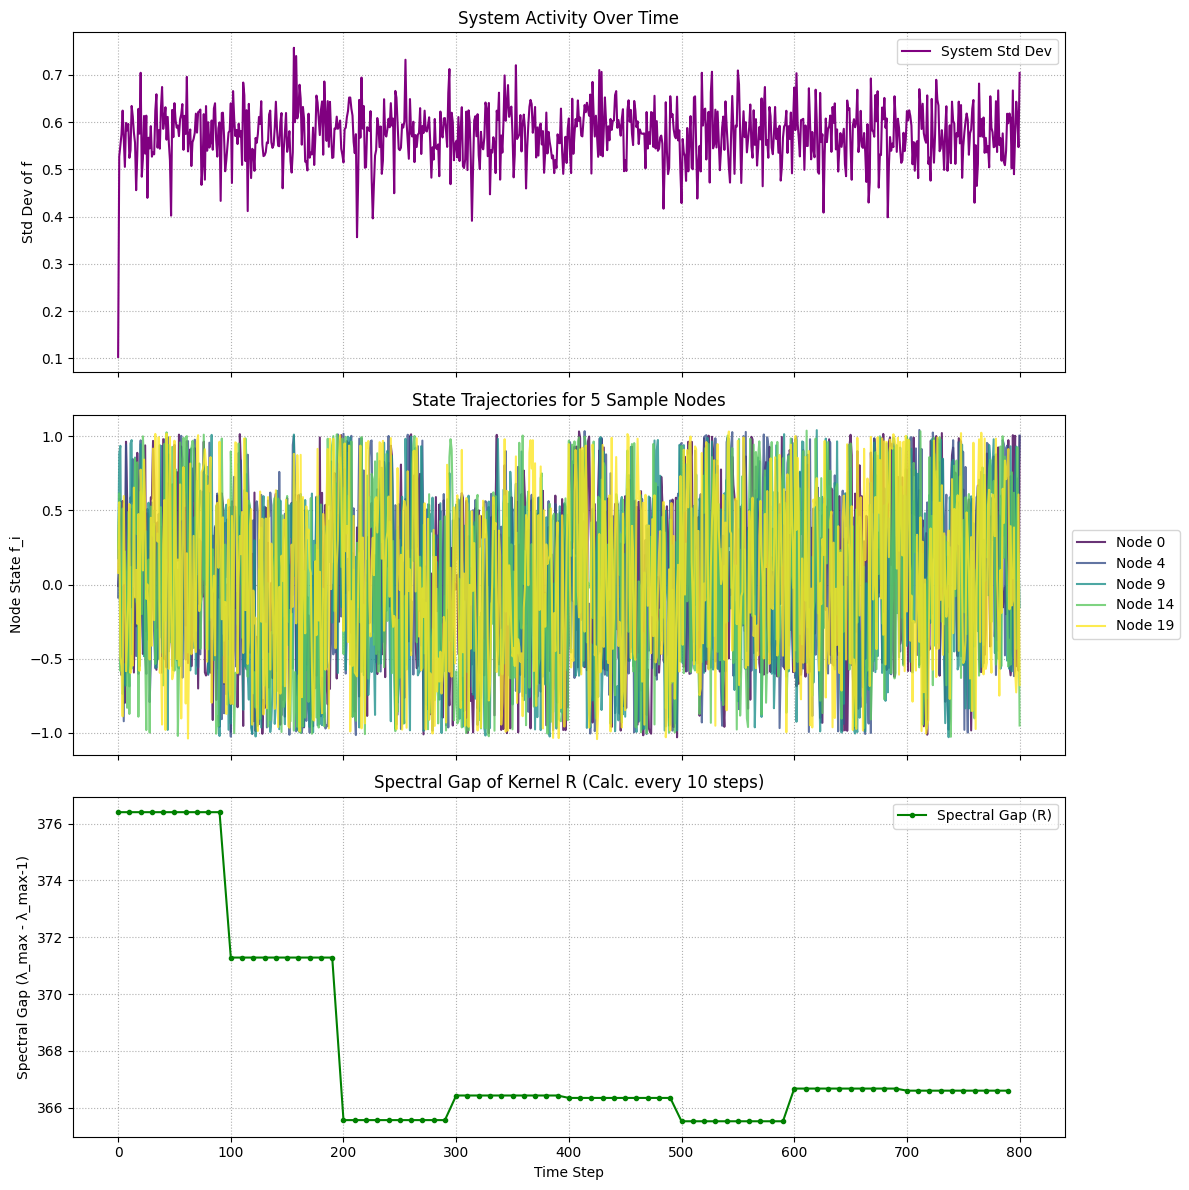


✅ Cell 9 execution complete.


In [11]:
# Cell 9: Analysis and Visualization (ADAPTED FOR SINGLE ORGANISM & OS IMPORT)

import os # <--- ADD THIS IMPORT
import numpy as np
import pandas as pd # Keep pandas for checking spectral gap validity
import matplotlib.pyplot as plt
import warnings # Keep warnings

print("\n--- Analysis and Visualization (Single System) ---")

# --- Check Prerequisites ---
visualization_error = False
if 'organisms' not in globals() or not isinstance(organisms, list) or not organisms:
    print("⚠️ Cannot visualize: 'organisms' list missing or empty.")
    visualization_error = True
elif 'simulation_successful' not in globals() or not simulation_successful:
    print("⚠️ Cannot visualize: Simulation did not complete successfully.")
    visualization_error = True
else:
    # Check if the first organism has the necessary history arrays
    org_data = organisms[0]
    required_histories = ['std_history', 'f_history', 'spectral_gap_history']
    missing_histories = [h for h in required_histories if h not in org_data or not isinstance(org_data[h], np.ndarray)]
    if missing_histories:
        print(f"⚠️ Cannot visualize: Missing or invalid history arrays in organism data: {missing_histories}")
        visualization_error = True

# --- Load Config for Filename (Safely) ---
# Define defaults in case config is missing
output_dir_plot = "."
exp_name_plot = "feedback_run"
spectral_gap_interval_plot = 10 # Default from Cell 7
N_plot = 20 # Default from Cell 3

# Try loading from global config if it exists
if 'config' in globals() and isinstance(config, dict):
    output_dir_plot = config.get('OUTPUT_DIR', output_dir_plot)
    exp_name_plot = config.get('EXPERIMENT_NAME', exp_name_plot)
    spectral_gap_interval_plot = config.get('SPECTRAL_GAP_INTERVAL', spectral_gap_interval_plot)
    N_plot = config.get('N', N_plot) # Get N for node sampling logic


# --- Proceed with Plotting only if no errors ---
if not visualization_error:
    org = organisms[0] # Get the single organism's data
    # Check history lengths are consistent (use std_history as reference length)
    base_len = len(org.get('std_history', []))
    if base_len == 0:
        print("⚠️ Cannot visualize: History arrays are empty.")
        visualization_error = True # Treat as error if history is empty
    else:
        # Ensure all histories have the same length after post-processing in Cell 8
        if not (len(org.get('f_history',[])) == base_len and len(org.get('spectral_gap_history',[])) == base_len):
            warnings.warn("History array lengths are inconsistent after simulation. Plotting might be truncated or fail.", RuntimeWarning)
            # Attempt to use the minimum length? Or flag error? For now, warn and proceed.
            base_len = min(len(org.get('f_history',[])), len(org.get('std_history',[])), len(org.get('spectral_gap_history',[])) )


    if not visualization_error and base_len > 0: # Check base_len > 0
        time_steps = np.arange(base_len) # Use actual history length

        fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

        # 1. Plot Global Activity (Std Dev)
        ax = axs[0]
        std_hist = org.get('std_history', [])[:base_len] # Slice to ensure length match
        if len(std_hist) == len(time_steps):
             ax.plot(time_steps, std_hist, label=f'System Std Dev', color='purple')
             ax.set_ylabel('Std Dev of f')
             ax.set_title('System Activity Over Time')
             ax.grid(True, linestyle=':')
             ax.legend()
        else: ax.text(0.5, 0.5, "Std Dev History Error", ha='center', va='center')


        # 2. Plot State Trajectories (Sample Nodes)
        ax = axs[1]
        num_nodes_to_plot = min(5, N_plot) # Use N loaded from config
        f_hist_np = org.get('f_history', np.array([[]]))[:base_len] # Slice

        if f_hist_np.ndim == 2 and f_hist_np.shape[1] == N_plot: # Check shape
            node_indices_to_plot = np.linspace(0, N_plot-1, num_nodes_to_plot, dtype=int)
            colors = plt.cm.viridis(np.linspace(0, 1, num_nodes_to_plot))
            for i, node_idx in enumerate(node_indices_to_plot):
                # Check index bounds again just in case
                if node_idx < f_hist_np.shape[1]:
                    ax.plot(time_steps, f_hist_np[:, node_idx], color=colors[i], alpha=0.8, label=f'Node {node_idx}')
            ax.set_ylabel('Node State f_i')
            ax.set_title(f'State Trajectories for {num_nodes_to_plot} Sample Nodes')
            ax.grid(True, linestyle=':')
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else: ax.text(0.5, 0.5, "State History Error or Shape Mismatch", ha='center', va='center')


        # 3. Plot Spectral Gap
        ax = axs[2]
        gap_hist = org.get('spectral_gap_history', [])[:base_len] # Slice
        if len(gap_hist) == len(time_steps):
            # Only plot where gap was calculated (not NaN)
            valid_gap_indices = np.where(pd.notna(gap_hist))[0]
            if len(valid_gap_indices) > 0:
                # Use time_steps corresponding to valid indices for x-axis
                ax.plot(time_steps[valid_gap_indices], gap_hist[valid_gap_indices],
                        marker='.', linestyle='-', label=f'Spectral Gap (R)', color='green')
                plot_label_gap = f'Spectral Gap of Kernel R (Calc. every {spectral_gap_interval_plot} steps)'
            else:
                ax.text(0.5, 0.5, "No valid spectral gap data", ha='center', va='center')
                plot_label_gap = "Spectral Gap (No Data)"
            ax.set_ylabel('Spectral Gap (λ_max - λ_max-1)')
            ax.set_title(plot_label_gap)
            ax.grid(True, linestyle=':')
            ax.set_xlabel('Time Step')
            ax.legend()
        else: ax.text(0.5, 0.5, "Spectral Gap History Error", ha='center', va='center')


        plt.tight_layout()
        # Save the plot
        # *** Use loaded/defaulted variables ***
        plot_filename = os.path.join(output_dir_plot, f"{exp_name_plot}_single_system_dynamics.png")
        try:
             plt.savefig(plot_filename, dpi=150)
             print(f"\n✅ Analysis plot saved to: {plot_filename}")
        except Exception as e_save_plot:
             print(f"\n❌ Error saving analysis plot: {e_save_plot}")
        plt.show()
        plt.close(fig) # Close the figure after saving/showing

else: # visualization_error was True
     print("⚠️ Skipping visualization due to errors or lack of results.")


print("\n✅ Cell 9 execution complete.")